In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import mglearn
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix,precision_score,recall_score,f1_score,
    roc_curve,roc_auc_score,precision_recall_curve,accuracy_score,classification_report)

In [2]:
data = pd.read_csv("Energi_Viborg_Dandas_data.csv")

#drop columns not needed after asking the company about the meaning of these features

columns_to_be_removed = ['ID', 'mslink', 'XKoordinat','YKoordinat','LedningID','Dobbeltled','EjerKompon','SystemKode','KategoriAf','DatoUdf']
data=data.drop(columns_to_be_removed,axis='columns')

# in the column DatoSaneri is the date of repairing and if there is no date it means it is not repaired

data['DatoSaneri'].fillna(0, inplace=True)

# take only the pipes that are broken(by TV insection) now and the repaired ones

data_with_TVObsAndSaneri = data[data['TVObsKode'].isin([1]) | data['DatoSaneri'] > 0]

In [3]:
#get around 2077 rows with not broken pipes

data_not_broken = data[~data['TVObsKode'].isin([0]) | data['DatoSaneri'] == 0]
data_not_broken = data_not_broken.sample(n=2077) 

In [4]:
frames = [data_with_TVObsAndSaneri, data_not_broken]
  
data_final = pd.concat(frames)
data_final

,fra_kote,til_kote,Laengde,Fald,DiameterIn,MaterialeK,anlag_aar,TransportK,Funktionsk,TVObsKode,DatoOprett,DatoOpdate,DatoSaneri
36,34.72,33.48,64.88,19.112207,300.0,1.0,1939.0,1,0,0.0,2010,2014,1997.0
42,39.46,39.16,91.75,3.269755,400.0,1.0,1939.0,1,0,1.0,2010,2014,0.0
43,39.71,39.48,87.69,2.622876,300.0,1.0,1939.0,1,0,1.0,2010,2014,0.0
64,40.55,40.08,52.11,9.019382,250.0,1.0,1945.0,1,0,1.0,2010,2014,0.0
65,40.38,40.55,68.39,-2.485744,250.0,1.0,1945.0,1,0,1.0,2010,2014,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,33.50,32.95,38.87,14.149730,200.0,1.0,1965.0,1,10,0.0,2010,2014,0.0
6960,21.74,21.36,76.95,4.938272,225.0,4.0,2000.0,1,0,0.0,2010,2014,0.0
1566,44.60,44.60,34.51,0.000000,150.0,4.0,2001.0,1,0,0.0,2010,2014,0.0
13097,3.81,3.71,20.18,4.955401,200.0,1.0,1974.0,1,0,0.0,2010,2014,0.0


In [5]:
data = data_final

In [6]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(data.shape[0]))
data = data.dropna()
print("Number of rows after removing NaNs: {}".format(data.shape[0]))

Number of rows before removing NaNs: 4154
Number of rows after removing NaNs: 4154


In [7]:
#get data copied
datacopy = data


# add  age column

#get current year
from datetime import date
now = date.today().year


def age_df(datacopy):

    if (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] > 0) :
        return (now - datacopy['DatoSaneri'])
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri']== 0):
        return (now - datacopy['anlag_aar'])
    elif (datacopy['TVObsKode'] == 0) and (datacopy['DatoSaneri'] > 0):
        return (now - datacopy['DatoSaneri'])
    elif (datacopy['TVObsKode']== 0) and (datacopy['DatoSaneri']== 0):
        return (now - datacopy['anlag_aar'])

datacopy['Age'] = datacopy.apply(age_df, axis = 1)

In [8]:
# add a column 'PipeStatus'
# 1 as broken and 0 as not broken

def broken_df(datacopy):

    if (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] < (datacopy['DatoOpdate'])) and (datacopy['DatoSaneri'] != 0):
        return 1
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] >= (datacopy['DatoOpdate'])) and (datacopy['DatoSaneri'] != 0):
        return 0
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri']== 0):
        return 1
    elif (datacopy['TVObsKode'] == 0) and (datacopy['DatoSaneri'] > 0):
        return 0
    elif (datacopy['TVObsKode']== 0) and (datacopy['DatoSaneri']== 0):
        return 0

datacopy['PipeStatus'] = datacopy.apply(broken_df, axis = 1)

In [9]:
# datacopy = datacopy.sample(n=22) 
# datacopy

In [10]:
# data_fs= np.where(np.isnan(datacopy))
# data_fs
# row = datacopy.iloc[369] #index=1 => second row
# print(row)

In [11]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(datacopy.shape[0]))
datacopy = datacopy.dropna()
print("Number of rows after removing NaNs: {}".format(datacopy.shape[0]))

Number of rows before removing NaNs: 4154
Number of rows after removing NaNs: 4154


In [12]:
#drop columns not needed after adding new features

columns_to_be_removed = ['DatoOprett', 'DatoOpdate']
datacopy=datacopy.drop(columns_to_be_removed,axis='columns')
datacopy[0:-1]

,fra_kote,til_kote,Laengde,Fald,DiameterIn,MaterialeK,anlag_aar,TransportK,Funktionsk,TVObsKode,DatoSaneri,Age,PipeStatus
36,34.72,33.48,64.88,19.112207,300.0,1.0,1939.0,1,0,0.0,1997.0,24.0,0
42,39.46,39.16,91.75,3.269755,400.0,1.0,1939.0,1,0,1.0,0.0,82.0,1
43,39.71,39.48,87.69,2.622876,300.0,1.0,1939.0,1,0,1.0,0.0,82.0,1
64,40.55,40.08,52.11,9.019382,250.0,1.0,1945.0,1,0,1.0,0.0,76.0,1
65,40.38,40.55,68.39,-2.485744,250.0,1.0,1945.0,1,0,1.0,0.0,76.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8942,43.84,43.25,60.28,9.787658,160.0,4.0,2003.0,1,0,0.0,0.0,18.0,0
14635,33.50,32.95,38.87,14.149730,200.0,1.0,1965.0,1,10,0.0,0.0,56.0,0
6960,21.74,21.36,76.95,4.938272,225.0,4.0,2000.0,1,0,0.0,0.0,21.0,0
1566,44.60,44.60,34.51,0.000000,150.0,4.0,2001.0,1,0,0.0,0.0,20.0,0


In [13]:

# creating features set and target

columns_to_be_removed = ['PipeStatus']
data_features= datacopy.drop(columns_to_be_removed,axis='columns')
columns_to_be_removed = ['fra_kote','til_kote', 'Laengde','Fald','DiameterIn','MaterialeK',
                         'anlag_aar','TransportK','Funktionsk','TVObsKode','DatoSaneri','Age']
data_target=datacopy.drop(columns_to_be_removed,axis='columns')


In [14]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(data.shape[0]))
data = data.dropna()
print("Number of rows after removing NaNs: {}".format(data.shape[0]))

Number of rows before removing NaNs: 4154
Number of rows after removing NaNs: 4154


# Tuning parameters with test-set split and grid search cross validation

In [44]:
# Divide the data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data_target, stratify=data_target, random_state=42)

In [45]:
#List Hyperparameters that we want to tune by cross validation

max_depth = [3,4,5,6,7,8,9,10,20,30]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2','auto']

#Convert to dictionary
hyperparameters = dict(max_depth=max_depth, max_features=max_features, criterion=criterion)

#Create new decision tre object
dec_tree = DecisionTreeClassifier()

#Use GridSearch
clf = GridSearchCV(dec_tree, hyperparameters, cv=5,return_train_score=True, scoring="recall")

#Fit the model
best_model = clf.fit(X_train, y_train)

#Print The value of best Hyperparameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
    
print("Accuracy on training set: {:.3f}".format(best_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(best_model.score(X_test, y_test)))

Best max_depth: 20
Best max_features: auto
Best criterion: entropy
Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [46]:
#Create forest Object.
a = best_model.best_estimator_.get_params()['max_depth']
b = best_model.best_estimator_.get_params()['max_features']
c = best_model.best_estimator_.get_params()['criterion']
dec_tree = DecisionTreeClassifier(criterion= c, max_depth= a, max_features= b, random_state=0)

#Create x and y variables.
x = data_features
y = data_target

#Split data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

#Training the model.
dec_tree.fit(X_train, y_train)

#Predict test data set.
y_pred = dec_tree.predict(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       835
           1       1.00      1.00      1.00       204

    accuracy                           1.00      1039
   macro avg       1.00      1.00      1.00      1039
weighted avg       1.00      1.00      1.00      1039



0.9975490196078431

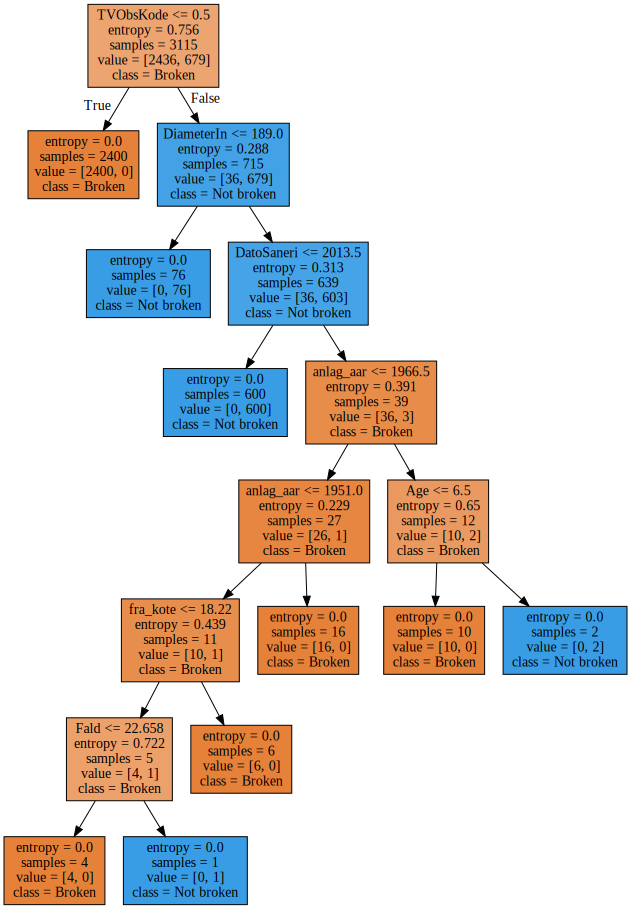

In [47]:
dot_data = export_graphviz(dec_tree, out_file=None,
                           class_names=["Broken","Not broken"],
                           feature_names=data_features.columns, 
                           filled=True)

graph = graphviz.Source(dot_data)
graph

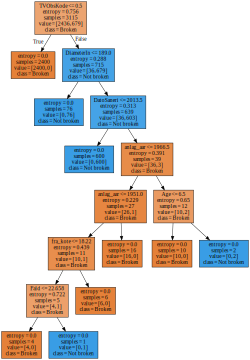

In [48]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"5,5!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

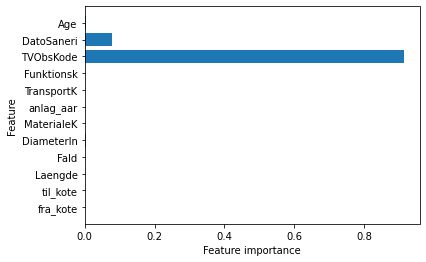

In [49]:
def plot_feature_importances_pipes(model):
    n_features = data_features.shape[1]
    feature_names=data_features.columns
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_pipes(dec_tree)

Confusion matrix:  
[[835   0]
 [  1 203]]

Accuracy: 
0.9990375360923965

Precision: 
1.0

Recall: 
0.9950980392156863

F1: 
0.9975429975429976
Area under curve: 
0.9975490196078431
[2 1 0]


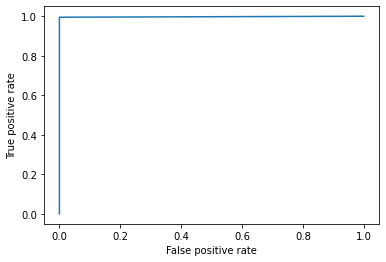

In [50]:
# check the model performance

#Predict test data set.
y_pred = dec_tree.predict(X_test)

print("Confusion matrix:  \n{}\n".format(confusion_matrix(y_test, y_pred)))
print("Accuracy: \n{}\n".format(dec_tree.score(X_test,y_test)))
print("Precision: \n{}\n".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: \n{}\n".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: \n{}".format(f1_score(y_test, y_pred,pos_label=1)))


#ROC curve
fpr,tpr,thresh = roc_curve(y_test,dec_tree.predict(X_test))
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("Area under curve: \n{}".format(roc_auc_score(y_test,dec_tree.predict(X_test))) )
print(thresh)



[0 1]


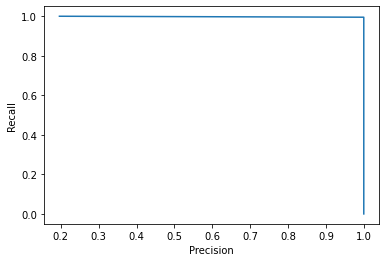

In [51]:
# precision recall curve
prec,rec,thresh1 = precision_recall_curve(y_test,dec_tree.predict(X_test))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(prec,rec)
print(thresh1)

# Tuning parameters with validation set split

In [52]:
# Divide the data into training, test and validation

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=43)
print("Size of training set:{}".format(X_train.shape[0]))
print("Size of validation set:{}".format(X_val.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training set:2336
Size of validation set:779
Size of test set:1039


In [53]:
best_score = 0

for max_depth in [3,4,5,6,7,8,9,10,20,30]:
    for criterion in ['gini', 'entropy']:
        for max_features in ['sqrt', 'log2','auto']:
             # Learn the model 
                    dec_tree = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
                    dec_tree.fit(X_train, y_train)
                        
                        # Evaluate the model
                    score = dec_tree.score(X_val, y_val)
                        
                         # If improvement, store score and parameter
                    if score>best_score:
                        best_score = score
                        best_max_depth = max_depth
                        best_max_features= max_features
                        best_criterion = criterion


# Build a model on the combine training and valiation data
dec_tree = DecisionTreeClassifier(max_depth= best_max_depth, max_features=best_max_features, criterion=best_criterion)
dec_tree.fit(X_trainval, y_trainval)

print("Best best_max_depth found: {}".format(best_max_depth))
print("Best best_max_features found: {}".format(best_max_features))
print("Best best_criterion found: {}".format(best_criterion))
print("Best score on validation set: {}".format(best_score))
print("Score on training/validation set: {}".format(dec_tree.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(dec_tree.score(X_test, y_test)))

Best best_max_depth found: 3
Best best_max_features found: auto
Best best_criterion found: gini
Best score on validation set: 0.9987163029525032
Score on training/validation set: 0.7881219903691814
Score on test set: 0.8075072184793071


In [54]:
#Predict test data set.
y_pred = dec_tree.predict(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       835
           1       0.62      0.05      0.09       204

    accuracy                           0.81      1039
   macro avg       0.72      0.52      0.49      1039
weighted avg       0.77      0.81      0.73      1039



0.5209169895503112

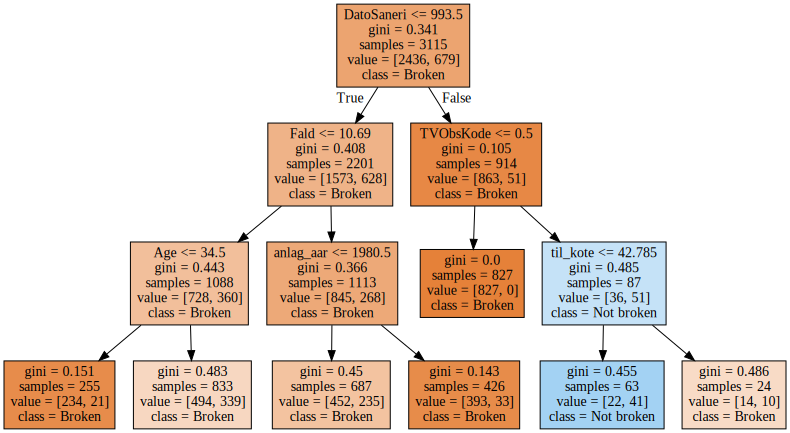

In [55]:
dot_data = export_graphviz(dec_tree, out_file=None,
                           class_names=["Broken","Not broken"],
                           feature_names=data_features.columns, 
                           filled=True)

graph = graphviz.Source(dot_data)
graph

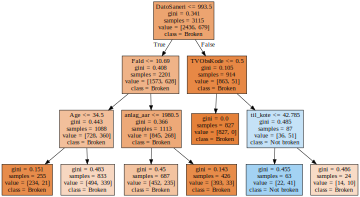

In [56]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"5,5!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

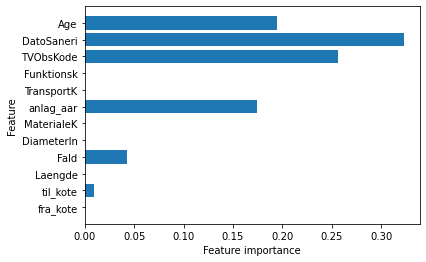

In [57]:
def plot_feature_importances_pipes(model):
    n_features = data_features.shape[1]
    feature_names=data_features
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_pipes(dec_tree)

Confusion matrix:  
[[829   6]
 [194  10]]

Accuracy: 
0.8075072184793071

Precision: 
0.625

Recall: 
0.049019607843137254

F1: 
0.0909090909090909
Area under curve: 
0.5209169895503112
[2 1 0]


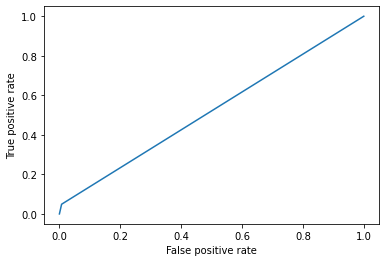

In [58]:
# check the model performance

#Predict test data set.
y_pred = dec_tree.predict(X_test)

print("Confusion matrix:  \n{}\n".format(confusion_matrix(y_test, y_pred)))
print("Accuracy: \n{}\n".format(dec_tree.score(X_test,y_test)))
print("Precision: \n{}\n".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: \n{}\n".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: \n{}".format(f1_score(y_test, y_pred,pos_label=1)))


#ROC curve
fpr,tpr,thresh = roc_curve(y_test,dec_tree.predict(X_test))
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("Area under curve: \n{}".format(roc_auc_score(y_test,dec_tree.predict(X_test))) )
print(thresh)



[0 1]


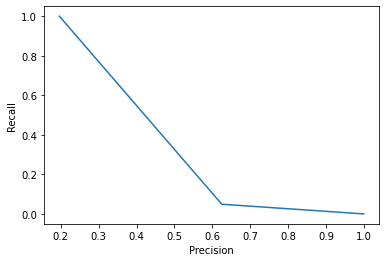

In [59]:
# precision recall curve
prec,rec,thresh1 = precision_recall_curve(y_test,dec_tree.predict(X_test))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(prec,rec)
print(thresh1)

# Tuning parameters with cross validation

In [60]:
# Divide the data into training and test , no validation data

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
print("Size of training set:{}".format(X_train.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training set:2336
Size of test set:1039


In [61]:
best_score = 0

for max_depth in [3,4,5,6,7,8,9,10,20,30]:
    for criterion in ['gini', 'entropy']:
        for max_features in ['sqrt', 'log2','auto']:
            # Learn the model 
            dec_tree = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
        
            # Perform cross validation
            scores = cross_val_score(dec_tree, X_trainval, y_trainval, cv=5)
        
            # Compute the mean score
            score = scores.mean()
        
        
           # If improvement, store score and parameter
            if score>best_score:
                best_score = score
                best_max_depth = max_depth
                best_max_features= max_features
                best_criterion = criterion

# Build a model on the combine training and valiation data
dec_tree = DecisionTreeClassifier(max_depth= best_max_depth, max_features=best_max_features, criterion=best_criterion)
dec_tree.fit(X_trainval, y_trainval)

print("Best best_max_depth found: {}".format(best_max_depth))
print("Best best_max_features found: {}".format(best_max_features))
print("Best best_criterion found: {}".format(best_criterion))
print("Best average score: {}".format(best_score))
print("Score on training/validation set: {}".format(dec_tree.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(dec_tree.score(X_test, y_test)))

Best best_max_depth found: 20
Best best_max_features found: log2
Best best_criterion found: gini
Best average score: 0.9942215088282504
Score on training/validation set: 1.0
Score on test set: 0.9980750721847931


In [62]:
#Predict test data set.
y_pred = dec_tree.predict(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       835
           1       1.00      0.99      1.00       204

    accuracy                           1.00      1039
   macro avg       1.00      1.00      1.00      1039
weighted avg       1.00      1.00      1.00      1039



0.9950980392156863

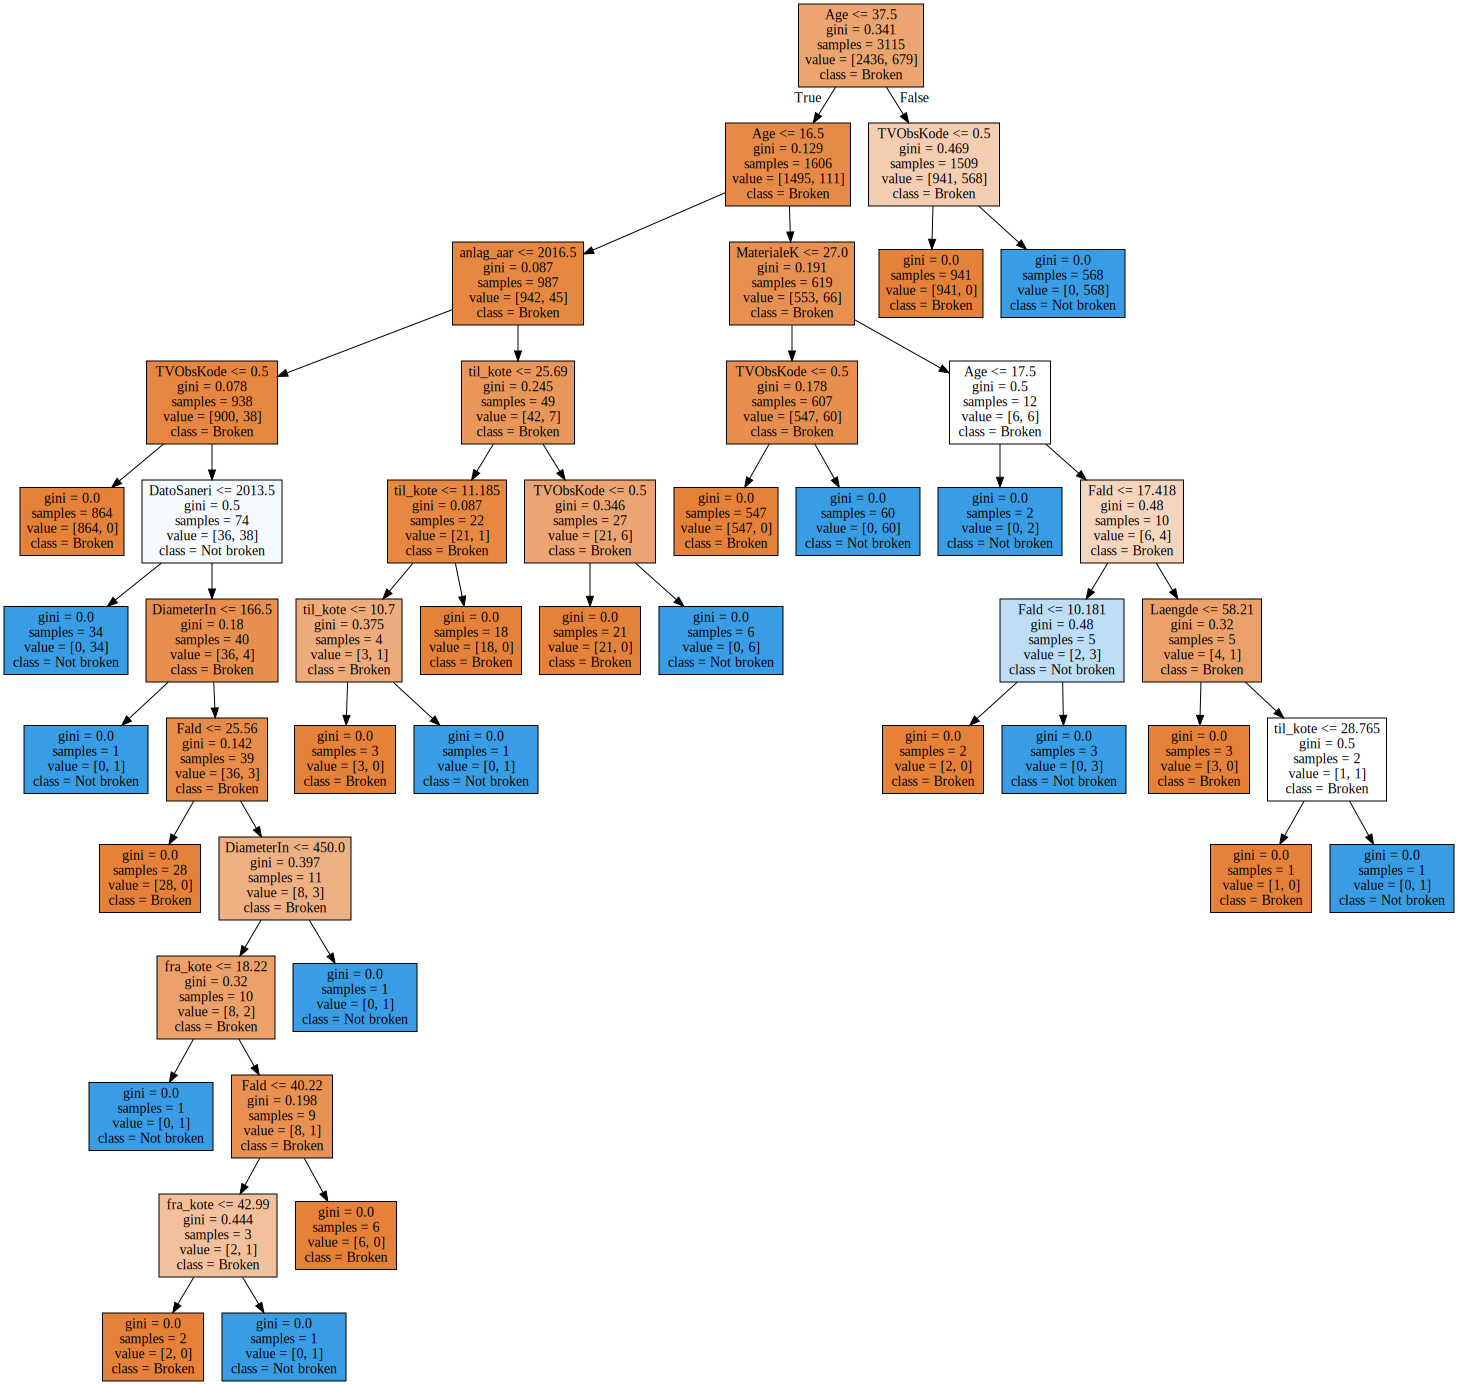

In [63]:
dot_data = export_graphviz(dec_tree, out_file=None,
                           class_names=["Broken","Not broken"],
                           feature_names=data_features.columns, 
                           filled=True)

graph = graphviz.Source(dot_data)
graph

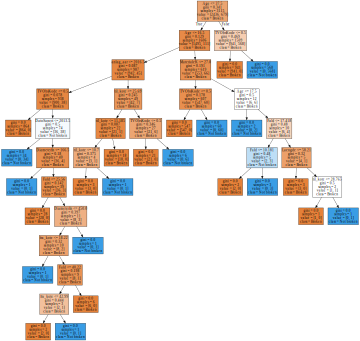

In [64]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"5,5!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

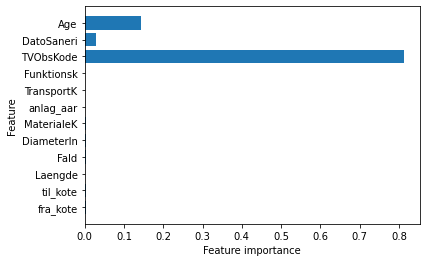

In [66]:
def plot_feature_importances_pipes(model):
    n_features = data_features.shape[1]
    feature_names=data_features.columns
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_pipes(dec_tree)

Confusion matrix:  
[[835   0]
 [  2 202]]

Accuracy: 
0.9980750721847931

Precision: 
1.0

Recall: 
0.9901960784313726

F1: 
0.9950738916256158
Area under curve: 
0.9950980392156863
[2 1 0]


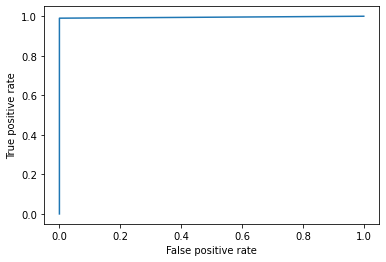

In [67]:
# check the model performance

#Predict test data set.
y_pred = dec_tree.predict(X_test)

print("Confusion matrix:  \n{}\n".format(confusion_matrix(y_test, y_pred)))
print("Accuracy: \n{}\n".format(dec_tree.score(X_test,y_test)))
print("Precision: \n{}\n".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: \n{}\n".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: \n{}".format(f1_score(y_test, y_pred,pos_label=1)))


#ROC curve
fpr,tpr,thresh = roc_curve(y_test,dec_tree.predict(X_test))
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("Area under curve: \n{}".format(roc_auc_score(y_test,dec_tree.predict(X_test))) )
print(thresh)



[0 1]


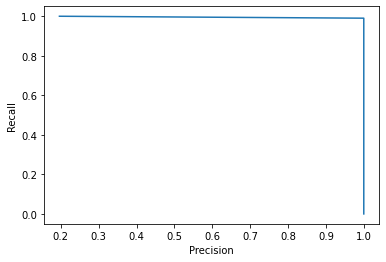

In [68]:
# precision recall curve
prec,rec,thresh1 = precision_recall_curve(y_test,dec_tree.predict(X_test))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(prec,rec)
print(thresh1)